# Importing and cleaning

In [1]:
import pandas as pd
import graphviz 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc
import statistics
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import cm
from sklearn.metrics import silhouette_samples

In [2]:
df = pd.read_csv('C:/Users/Guglielmo/Desktop/AppleStore.csv', sep=',', header=0, index_col=0)

## Cleaning

Dropping the non relevant columns for our analysis. We don't care about the ID, the name of the app, its size, currency (they're all USD), current version, and whatever vpp_lic is (they're all == 1 anyway).

In [3]:
df = df.drop(['id','track_name', 'size_bytes', 'currency', 'ver', 'vpp_lic'], axis = 1)

Dropping the categorical variables.

In [4]:
df_nocat = df.drop(['cont_rating', 'prime_genre'], axis=1)

And storing them for later use.

In [5]:
df_cont = df[['cont_rating']]
df_gen = df[['prime_genre']]

Let's take a look at the data.

In [6]:
#sns.pairplot(df_nocat, diag_kind='kde')
#plt.show()

Not really representative or useful at the moment...

However, we can see from some univariate distributions that there are few outliers. We can remove them in order to prevent our following analyses from being somewhat skewed.

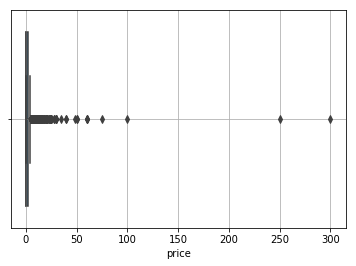

In [7]:
sns.boxplot(df_nocat['price'])
plt.grid()
plt.show()

### Removing outliers

Let's normalize data and transform it in absolute value so that we can identify the outliers (value > 3), that is to say they're above the 3rd standard deviation.

In [8]:
z_score = np.abs(sc.zscore(df_nocat))
# normalizes data, returns absolute value

df_nocat = df_nocat.reset_index(drop=True)
# resets the index of df_nocat, start at 0

rem_row = np.unique(np.where(z_score > 3)[0])
# returns indexes of the rows that have at least
# one z_score > 3

df_nocat_noout = df_nocat.drop(rem_row, axis=0)
# removes rows that contain outliers,
# saves in new dataframe

In [9]:
# sns.pairplot(df_nocat_noout, diag_kind='kde')
# plt.show()

A little better. Now at least univariate distribution of price is something more than a vertical line above the 0 value. Sure, the majority of apps are free, but the previous KDE was unreadable.

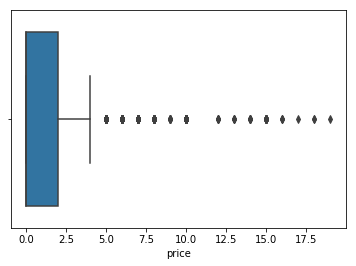

In [10]:
sns.boxplot(df_nocat_noout['price'])
plt.show()

# Starter analysis

## Correlation heatmap

Let's build a correlation heatmap to see if there is any relevant correlation between the variables.

In [11]:
corr = df_nocat_noout.corr()

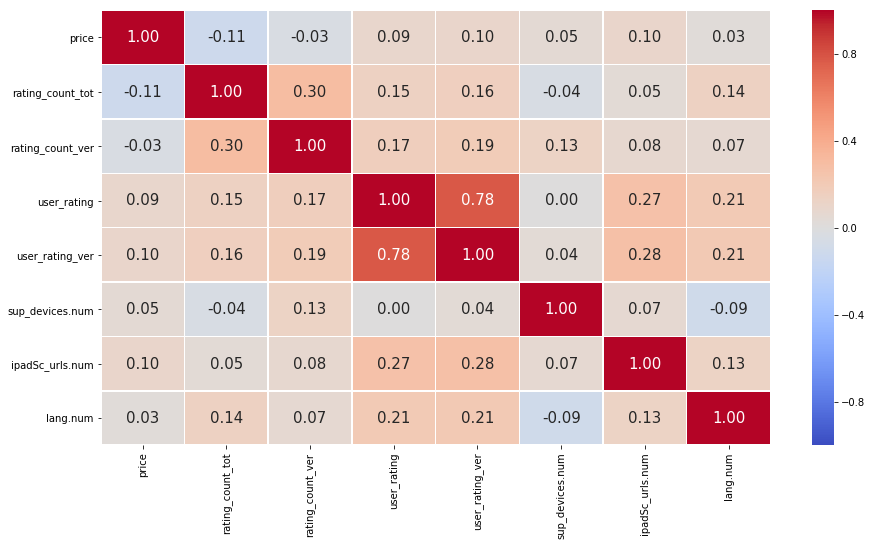

In [12]:
fig, ax = plt.subplots(figsize=(15,8))

hm = sns.heatmap(corr,
                 ax=ax,
                 cmap='coolwarm',
                 vmin=-1.0,
                 vmax=1.0,
                 annot=True,
                 fmt='.2f',
                 annot_kws={'size':15},
                 linewidths=0.5)

There's very low correlations between most attributes, looks like we need go further and use all the variables for our analysis.

Next we'll try to put user rating as "class", drop it from the DF, put back categorical variables, run a decision tree, see results, ????, profit.

## Decision tree

### Setup

We start by adding back the 2 categorical variables that we removed before, of course removing the rows that correspond to outlier data.

In [13]:
df_cont = df_cont.reset_index(drop=True)
df_gen = df_gen.reset_index(drop=True)
# resets the index of content rating and genre attributes, start at 0

df_cont = df_cont.drop(rem_row, axis=0)
df_gen = df_gen.drop(rem_row, axis=0)

# removes rows that contain outliers,
# saves in same dataframe

In [14]:
df_tree = pd.concat([df_nocat_noout, df_cont, df_gen], axis = 1)
#puts back the 2 attribute columns in the dataframe

In [15]:
df_tree['prime_genre'] = df_tree['prime_genre'].str.replace('&','and')
#replaces "&" with "and" to avoid errors in the decision tree

We want to find out if _user rating_ is somewhat functionally dependent on a combination of other attributes, and to what degree. Let's group ratings arbitrarily, with this criteria:
- Last version rating > 3.5 : __Good__
- Last version rating ≥ 3.0 : __Okish__
- Last version rating < 3.0 : __Bad__

In [16]:
conditions = [
    (df_nocat_noout['user_rating_ver'] > 3.5),
    ((df_nocat_noout['user_rating_ver'] > 2.5) & (df_nocat_noout['user_rating_ver'] <= 3.5)),
    (df_nocat_noout['user_rating_ver'] < 3.0)]
choices = ['Good', 'Okish', 'Bad']

df_tree['Grade'] = np.select(conditions, choices, default=None)

Then we drop the user rating attributes from the DF.

In [17]:
df_tree = df_tree.drop(['user_rating_ver','user_rating'], axis=1)

Let's also drop rating count because otherwise the tree makes no sense.

In [18]:
df_tree = df_tree.drop(['rating_count_tot','rating_count_ver'], axis=1)

Assign the Grade column to a new DF.

In [19]:
df_grade = df_tree[['Grade']]

And drop it again from the original DF.

In [20]:
df_tree = df_tree.drop('Grade', axis=1)

There is an issue now. Sklearn decision tree does not handle categorical variables (such as _genre_). Only numerical ones. The second problem is that if we convert our categorical variables to numbers, the algorithm will think that they're ordinal, and therefore the higher the number the better, which in this case is obviously not only wrong, but also nonsensical.

We need to transform the categorical variables into __dummy__ ones.

### "Dummyfication" of categorical variables (one hot encoding)

In [21]:
one_hot_data = pd.get_dummies(df_tree, columns=['cont_rating','prime_genre'])

In [22]:
one_hot_data.head()

,price,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating_12+,cont_rating_17+,cont_rating_4+,cont_rating_9+,prime_genre_Book,prime_genre_Business,...,prime_genre_News,prime_genre_Photo and Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,3.99,38,5,10,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.00,37,5,23,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.00,37,5,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.99,47,5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.00,37,0,19,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_data, df_grade)
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 4854 samples in the training dataset
There are 1619 samples in the testing dataset
Each sample has 31 features


In [24]:
#rnd_state = 666
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = 42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [25]:
y_test = np.array(y_test)
y_train = np.array(y_train)
#transforms the dataframes into arrays so we can use them for comparison

In [26]:
y_predicted_train = clf.predict(X_train)
accuracy_train = np.mean(y_train == y_predicted_train)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_train))

The accuracy on training set is 48.6%


In [27]:
y_predicted_test = clf.predict(X_test)
accuracy_test = np.mean(y_test == y_predicted_test)*100
print("The accuracy on test set is {0:.1f}%".format(accuracy_test))

The accuracy on test set is 49.1%


# VARI METODI PER FEATURE SELECTION

Come fatto in classe, per predire il Grade


In [28]:
conditions = [
    (df_nocat_noout['user_rating_ver'] > 3.5),
    ((df_nocat_noout['user_rating_ver'] > 2.5) & (df_nocat_noout['user_rating_ver'] <= 3.5)),
    (df_nocat_noout['user_rating_ver'] < 3.0)]
choices = ['Good', 'Okish', 'Bad']

df_tree['Grade'] = np.select(conditions, choices, default=None)
df_grade = df_tree[['Grade']]

X_train, X_test, y_train, y_test = train_test_split(one_hot_data, df_grade)


y_test = np.array(y_test)
y_train = np.array(y_train)
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [29]:
y_pred=rf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6349598517603459


In [30]:
feature_imp = pd.Series(clf.feature_importances_, index=list(one_hot_data)).sort_values(ascending=False)
feature_imp

lang.num                          0.201069
price                             0.167045
ipadSc_urls.num                   0.136582
sup_devices.num                   0.130900
cont_rating_4+                    0.040039
prime_genre_Games                 0.039134
prime_genre_Entertainment         0.026202
cont_rating_17+                   0.026183
cont_rating_12+                   0.025720
cont_rating_9+                    0.025563
prime_genre_Photo and Video       0.015944
prime_genre_Utilities             0.014788
prime_genre_Education             0.014069
prime_genre_Music                 0.013306
prime_genre_Social Networking     0.012565
prime_genre_Book                  0.012444
prime_genre_Lifestyle             0.011006
prime_genre_Health and Fitness    0.010257
prime_genre_Productivity          0.010049
prime_genre_Shopping              0.009774
prime_genre_Navigation            0.008552
prime_genre_Finance               0.007595
prime_genre_Reference             0.006620
prime_genre

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
estimator = DecisionTreeClassifier(criterion="entropy", random_state = 42)
# estimator = RandomForestClassifier(n_estimators=10
#                                    , max_depth=None
#                                    , min_samples_split=2
#                                    , random_state=r_state
#                                   )
from sklearn.model_selection import StratifiedKFold

# the call to StratifiedKFold sets the random state
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, one_hot_data, df_grade, scoring="accuracy", cv = cv)

# The accuracy is stored into a dictionary, with label 'full'
scores = {'full':np.mean(sc)}
print("The CV accuracy with full data is {0:.3f}%".format(scores['full']))

The CV accuracy with full data is 0.601%


In [32]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
# feature extraction with SelectKBest - supervised
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from functools import partial

# the "partial" function is used to pass the "random_state" 
#    parameter to the callable score function
kbest = SelectKBest(
    score_func=partial(mutual_info_classif,random_state=42)
    , k=5)
fit = kbest.fit(one_hot_data,np.array(df_grade).ravel())
X_red = fit.transform(one_hot_data)
X_red.shape

(6473, 5)

In [33]:
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, X_red, df_grade
                         , scoring="accuracy", cv = cv)
scores['SelectKBest']=np.mean(sc)
print("The CV accuracy with 'SelectKBest' reduced data is {0:.3f}%".format(scores['SelectKBest']))

The CV accuracy with 'SelectKBest' reduced data is 0.640%


In [34]:
# Feature Extraction with RFE - supervised
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# feature extraction
# the model below will be used to 
model = LogisticRegression(solver='lbfgs', random_state = 42, multi_class="auto", max_iter=1400)
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(one_hot_data, np.array(df_grade).ravel())
X_red = fit.transform(one_hot_data)

In [35]:
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, X_red, df_grade, scoring="accuracy", cv = cv)
scores['RFE']=np.mean(sc)
print("The CV accuracy with 'RFE' reduced data is {0:.3f}%".format(scores['RFE']))

The CV accuracy with 'RFE' reduced data is 0.628%


In [36]:
# Feature Extraction with PCA - unsupervised
from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components=7)
fit = pca.fit(one_hot_data)
# summarize components
print("Explained Variance:", fit.explained_variance_ratio_)
X_red = fit.transform(one_hot_data)

Explained Variance: [0.71087753 0.1155575  0.08583588 0.06201284 0.00738645 0.00448178
 0.00315838]


In [37]:
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, X_red, df_grade, scoring="accuracy", cv = cv)
scores['PCA']=np.mean(sc)
print("The CV accuracy with 'PCA' reduced data is {0:.3f}%".format(scores['PCA']))

The CV accuracy with 'PCA' reduced data is 0.602%


In [38]:
scores

{'full': 0.6007089619074308,
 'SelectKBest': 0.6402205205078209,
 'RFE': 0.6280100493539459,
 'PCA': 0.6016201166007094}

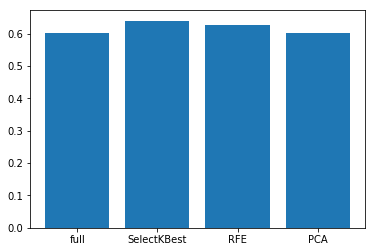

In [39]:
import matplotlib.pyplot as plt
plt.bar(range(len(scores)), list(scores.values()))
plt.xticks(range(len(scores)), scores.keys())
plt.show()

The accuracy on this method is less than a coinflip, therefore useless. Also, the resulting decision tree is a nightmare. Need to do some further analysis.

# STESSA COSA MA PER PREDIRE IL PREZZO

In [40]:
df_tree1 = pd.concat([df_nocat_noout, df_cont, df_gen], axis = 1)

In [320]:
# df_tree1.head()

In [42]:
conditions1 = [
    (df_tree1['price'] == 0.00),
    (df_tree1["price"]== 0.99),
    ((df_tree1['price'] >= 1.0) & (df_tree1['price'] <= 4.99)),
    (df_tree1['price'] >= 5.0),
     ]
choices1 = ['Free', 'Cheap', 'Medium', "Expensive"]

df_tree1['RangePrezzo'] = np.select(conditions1, choices1, default=None)

In [321]:
# df_tree1.head(2)

In [44]:
df_tree1=df_tree1.drop(["price"],axis=1)

In [45]:
df_rangeprice=df_tree1[["RangePrezzo"]]

In [46]:
df_tree1=df_tree1.drop(["RangePrezzo"],axis=1)

In [47]:
one_hot_data1 = pd.get_dummies(df_tree1, columns=['cont_rating','prime_genre'])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_data1, df_rangeprice)
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 4854 samples in the training dataset
There are 1619 samples in the testing dataset
Each sample has 34 features


In [49]:
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = 42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [50]:
y_test = np.array(y_test)
y_train = np.array(y_train)

In [51]:
y_predicted_train = clf.predict(X_train)
accuracy_train = np.mean(y_train == y_predicted_train)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_train))

The accuracy on training set is 41.9%


In [52]:
y_predicted_test = clf.predict(X_test)
accuracy_test = np.mean(y_test == y_predicted_test)*100
print("The accuracy on test set is {0:.1f}%".format(accuracy_test))

The accuracy on test set is 41.7%


In [53]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
y_pred=rf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.634342186534898


In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
estimator = DecisionTreeClassifier(criterion="entropy", random_state = 42)
# estimator = RandomForestClassifier(n_estimators=10
#                                    , max_depth=None
#                                    , min_samples_split=2
#                                    , random_state=r_state
#                                   )
from sklearn.model_selection import StratifiedKFold

# the call to StratifiedKFold sets the random state
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, one_hot_data1, df_rangeprice, scoring="accuracy", cv = cv)

# The accuracy is stored into a dictionary, with label 'full'
scores1 = {'full':np.mean(sc)}
print("The CV accuracy with full data is {0:.3f}%".format(scores1['full']))

The CV accuracy with full data is 0.541%


In [56]:
# the "partial" function is used to pass the "random_state" 
#    parameter to the callable score function
kbest = SelectKBest(
    score_func=partial(mutual_info_classif,random_state=42)
    , k=5)
fit = kbest.fit(one_hot_data1,np.array(df_rangeprice).ravel())
X_red = fit.transform(one_hot_data1)
X_red.shape

(6473, 5)

In [57]:
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, X_red, df_rangeprice
                         , scoring="accuracy", cv = cv)
scores1['SelectKBest']=np.mean(sc)
print("The CV accuracy with 'SelectKBest' reduced data is {0:.3f}%".format(scores1['SelectKBest']))

The CV accuracy with 'SelectKBest' reduced data is 0.521%


In [58]:
# model = LogisticRegression(solver='lbfgs', random_state = 42, multi_class="auto", max_iter=6000)
# rfe = RFE(model, n_features_to_select=5)
# fit = rfe.fit(one_hot_data1, np.array(df_rangeprice).ravel())
# X_red = fit.transform(one_hot_data1)

# #non funziona, troppe iterazioni

In [59]:
# cv = StratifiedKFold(n_splits=10,random_state=42)
# sc = cross_val_score(estimator, X_red, df_rangeprice, scoring="accuracy", cv = cv)
# scores1['RFE']=np.mean(sc)
# print("The CV accuracy with 'RFE' reduced data is {0:.3f}%".format(scores1['RFE']))

In [60]:
# Feature Extraction with PCA - unsupervised
from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components=7)
fit = pca.fit(one_hot_data1)
# summarize components
print("Explained Variance:", fit.explained_variance_ratio_)
X_red = fit.transform(one_hot_data1)

Explained Variance: [9.98729113e-01 1.27079524e-03 6.45065158e-08 1.11933082e-08
 6.46371086e-09 5.58349274e-09 1.24133785e-09]


In [61]:
cv = StratifiedKFold(n_splits=10,random_state=42)
sc = cross_val_score(estimator, X_red, df_rangeprice, scoring="accuracy", cv = cv)
scores1['PCA']=np.mean(sc)
print("The CV accuracy with 'PCA' reduced data is {0:.3f}%".format(scores1['PCA']))

The CV accuracy with 'PCA' reduced data is 0.510%


In [62]:
scores1

{'full': 0.540696928221842,
 'SelectKBest': 0.5210821599467887,
 'PCA': 0.5102514561163357}

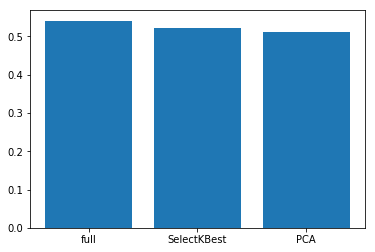

In [63]:
import matplotlib.pyplot as plt
plt.bar(range(len(scores1)), list(scores1.values()))
plt.xticks(range(len(scores1)), scores1.keys())
plt.show()

# BOXPLOT COMPARATIVO

In [64]:
df_nocat_noout.head(2)

,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,sup_devices.num,ipadSc_urls.num,lang.num
0,3.99,21292,26,4.0,4.5,38,5,10
1,0.00,161065,26,4.0,3.5,37,5,23


In [65]:
gigi1=df_nocat_noout.drop(["rating_count_tot", "rating_count_ver", "sup_devices.num"],axis=1)
# gigi1.boxplot(figsize=(15,8))
# plt.show()

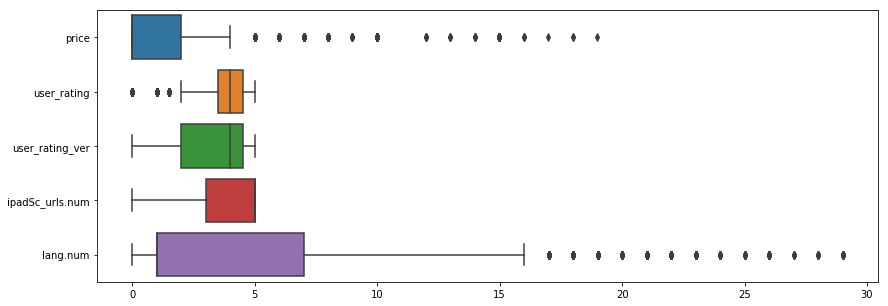

In [66]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 14,5

sns.boxplot(data=gigi1, orient="h")
plt.show()

In [67]:
gigi2=df_nocat_noout.drop(df_nocat_noout.columns[[0,3,4,5,6,7]],axis=1)

In [68]:
# from numpy import log10
# rcParams['figure.figsize'] = 15,5
# sns.boxplot(x=log10(gigi2["rating_count_tot"]+1),data=gigi2, orient="h")
# plt.show()
# sns.boxplot(x=log10(gigi2["rating_count_ver"]+1),data=gigi2, orient="h")
# plt.show()

In [217]:
gigi3=pd.concat([gigi1, df_gen], axis = 1)

In [325]:
# gigi3.head(2)

In [305]:
a=list(gigi3)

In [306]:
a.remove("prime_genre")

In [307]:
a

['price', 'user_rating', 'user_rating_ver', 'ipadSc_urls.num', 'lang.num']

In [326]:
# alfios=gigi3.groupby(["prime_genre"]).describe()
# alfios.head(3)

In [199]:
# exp1=df_nocat_noout["price"].describe()
# exp1

In [200]:
# obs1=alfios["price"].loc["Travel",:]
# obs1

In [198]:
# # import scipy.stats as stats

# list_genres=list(set(df["prime_genre"]))

# for i in a:
#     exp1=df_nocat_noout["{0}".format(i)].describe()
    
#     for item in list_genres:
#         obs1=alfios["{0}".format(i)].loc["{0}".format(item),:]
        
#         #print("{0}  ".format(i) + "  {0}".format(item))
        
#         if exp1[3]>0:
#             chi = stats.chisquare(f_obs= obs1[1:],  
#                                   f_exp= exp1[1:])
            
#             if (chi[1]<=0.05 and chi[1]>0.01):
#                 print("{0}  ".format(i) + "  {0}".format(item))
#                 print("MAYBE REJECT")
#                 print(chi)
#                 print("\n")
                
#             if chi[1]<=0.01:
#                 print("{0}  ".format(i) + "  {0}".format(item))
#                 print("REJEEEEEECT")
#                 print(chi)
#                 print("\n")
#         elif exp1[4]>0:
#             chi = stats.chisquare(f_obs= obs1[[1,2,4,5,6,7]],   
#                                   f_exp= exp1[[1,2,4,5,6,7]])
            
#             if (chi[1]<=0.05 and chi[1]>0.01):
#                 print("{0}  ".format(i) + "  {0}".format(item))
#                 print("MAYBE REJECT")
#                 print(chi)
#                 print("\n")
#             if chi[1]<=0.01:
#                 print("{0}  ".format(i) + "  {0}".format(item))
#                 print("REJEEEEEECT")
#                 print(chi)
#                 print("\n")
            
#         elif exp1[5]>0:
#             chi = stats.chisquare(f_obs= obs1[[1,2,5,6,7]],   
#                                   f_exp= exp1[[1,2,5,6,7]])
            
#             if (chi[1]<=0.05 and chi[1]>0.01):
#                 print("{0}  ".format(i) + "  {0}".format(item))
#                 print("MAYBE REJECT")
#                 print(chi)
#                 print("\n")
#             if chi[1]<=0.01:
#                 print("{0}  ".format(i) + "  {0}".format(item))
#                 print("REJEEEEEECT")
#                 print(chi)
#                 print("\n")
            
#         else:
#             chi = stats.chisquare(f_obs= obs1[[1,2,6,7]],   
#                                   f_exp= exp1[[1,2,6,7]])
            
#             if (chi[1]<=0.05 and chi[1]>0.01):
#                 print("{0}  ".format(i) + "  {0}".format(item))
#                 print("MAYBE REJECT")
#                 print(chi)
#                 print("\n")
#             if chi[1]<=0.01:
#                 print("{0}  ".format(i) + "  {0}".format(item))
#                 print("REJEEEEEECT")
#                 print(chi)
#                 print("\n")
        
        

# ALTRI BOXPLOT COMPARATIVI

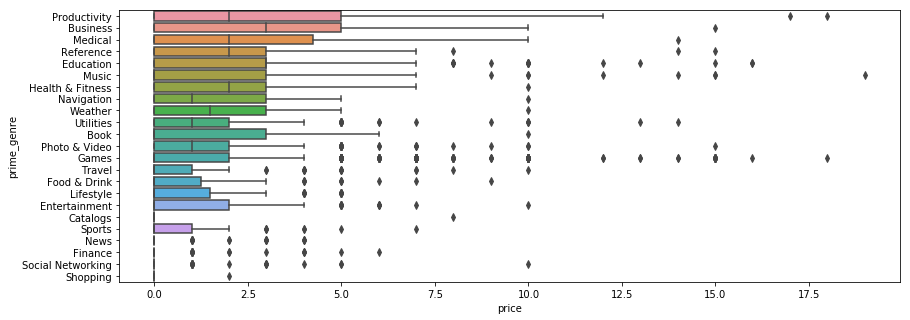

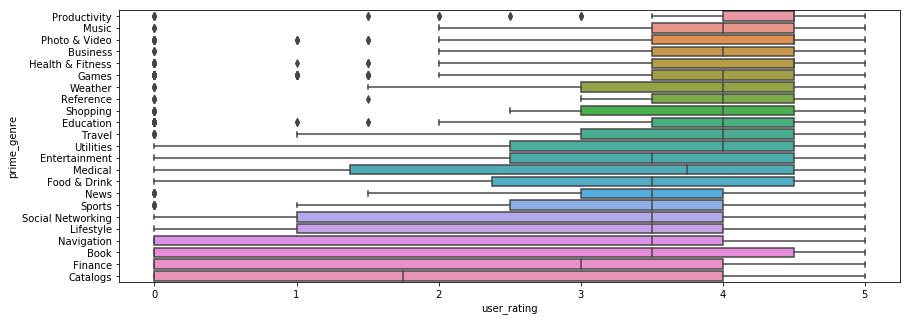

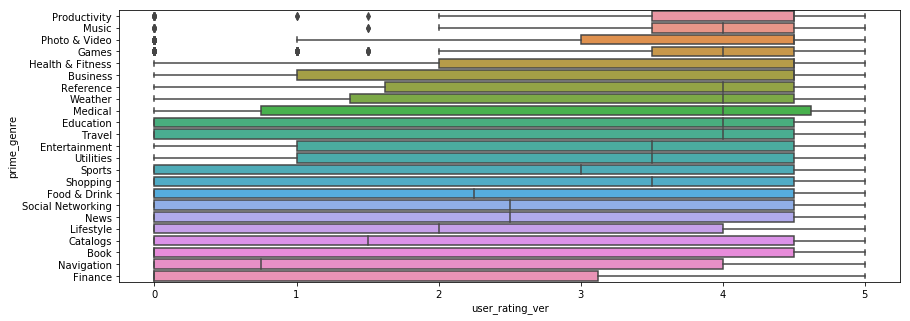

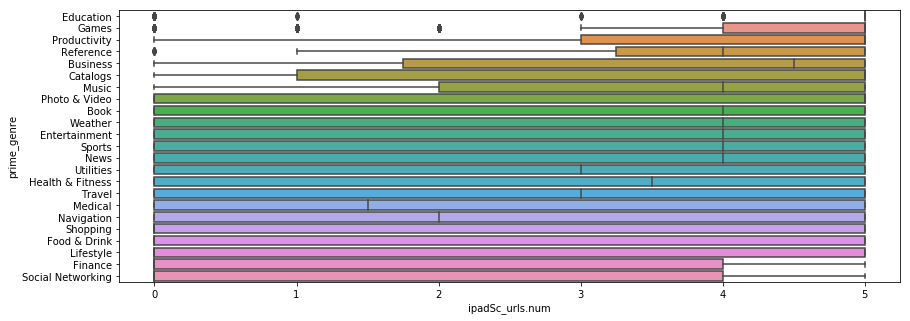

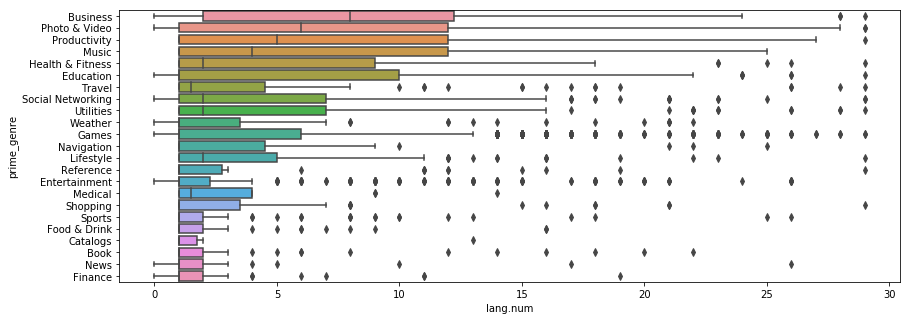

In [78]:
rcParams['figure.figsize'] = 14,5

for item in a:
    sns.boxplot(x=item,
                y="prime_genre",
                data=gigi3, 
                orient="h",
                order=gigi3.groupby(["prime_genre"]).mean()["{0}".format(item)].sort_values(ascending=False).index)
    plt.show()

# BOXPLOT ANALOGO, ROVESCIATO

In [79]:
list_genres=list(set(df["prime_genre"]))

In [80]:
# list_genres

In [81]:
df_tree = pd.concat([df_nocat_noout, df_cont, df_gen], axis = 1)
div_genre={}
for item in list_genres:
    div_genre["{0}".format(item)]=df_tree[df_tree["prime_genre"]==item]
    div_genre["{0}".format(item)]=div_genre["{0}".format(item)].drop(div_genre["{0}".format(item)].columns[6], axis=1)
    div_genre["{0}".format(item)]=div_genre["{0}".format(item)].reset_index(drop=True)

In [82]:
# (df["cont_rating"]).value_counts()

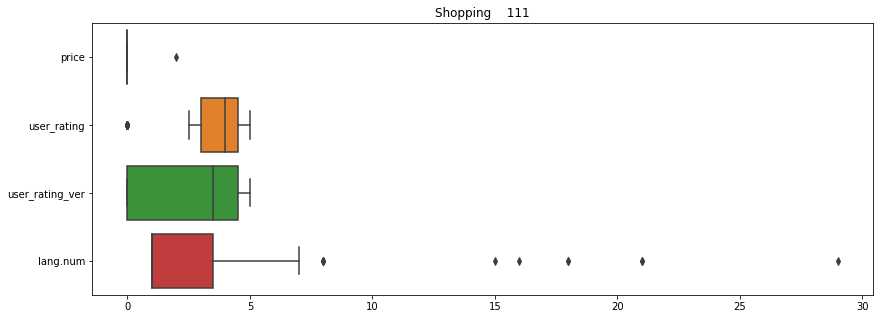

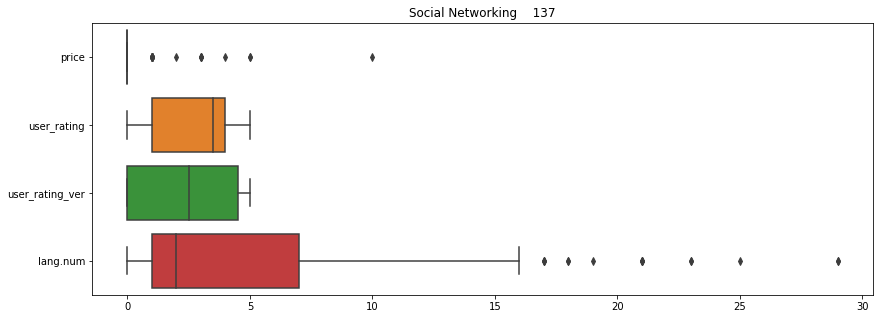

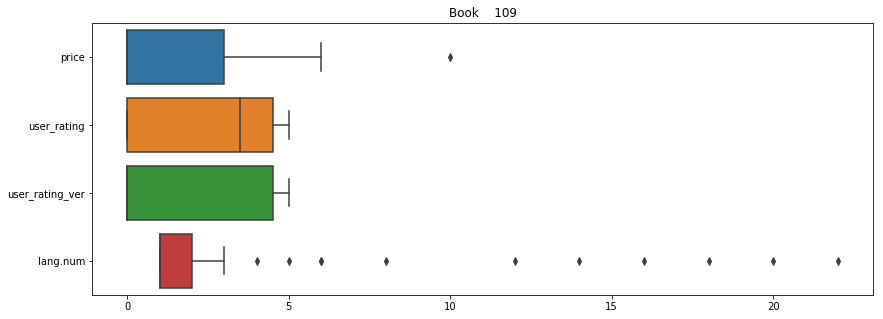

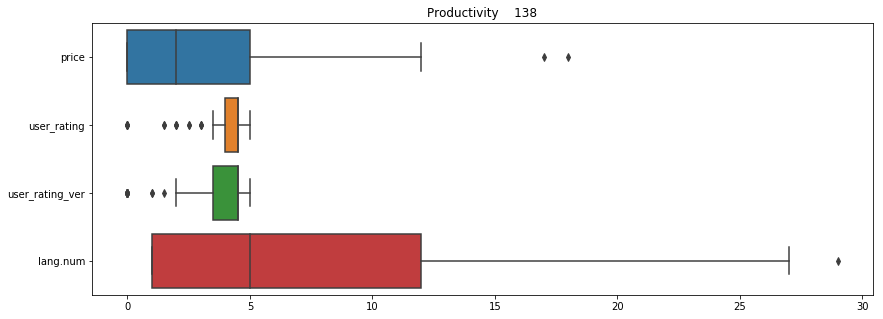

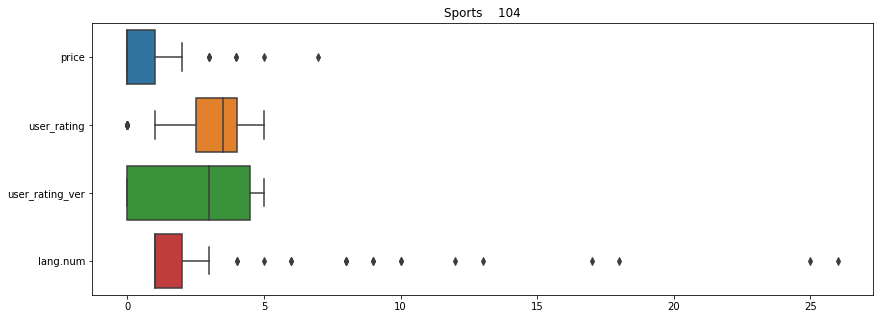

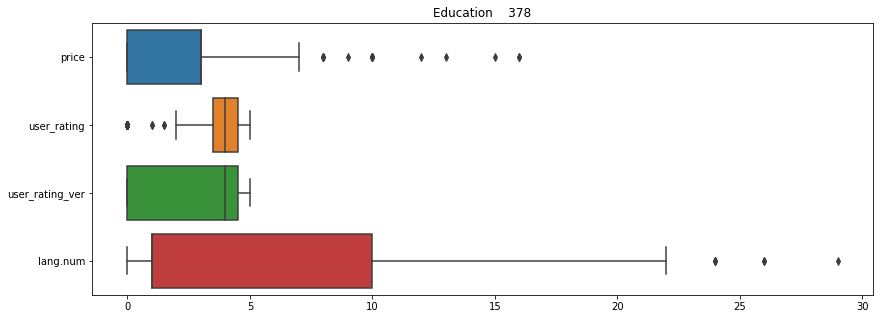

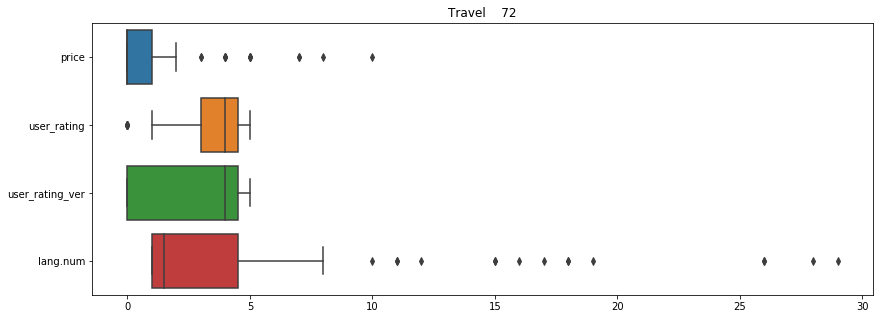

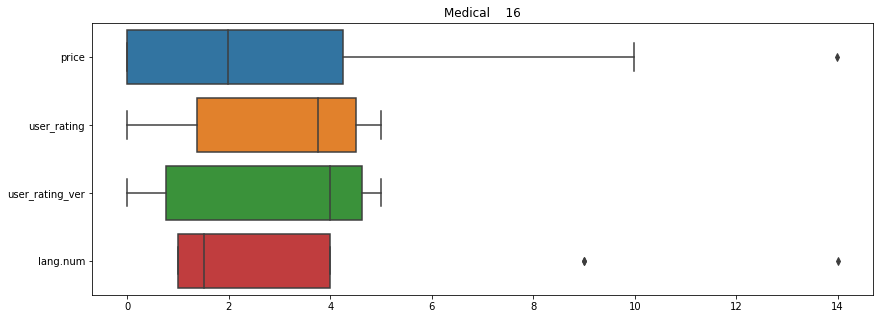

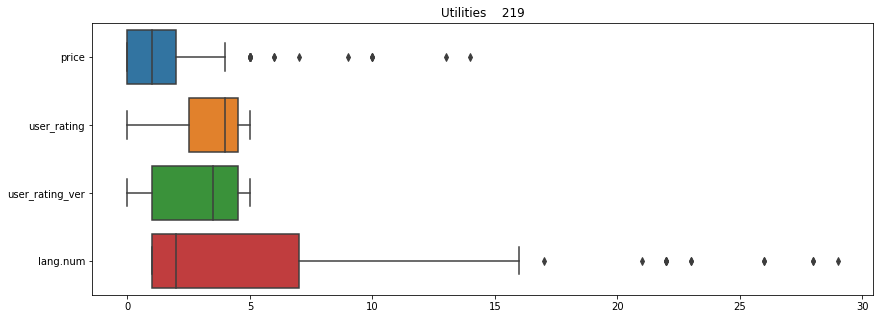

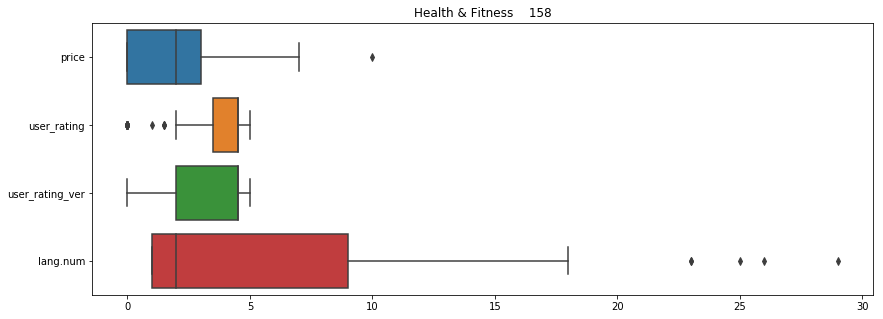

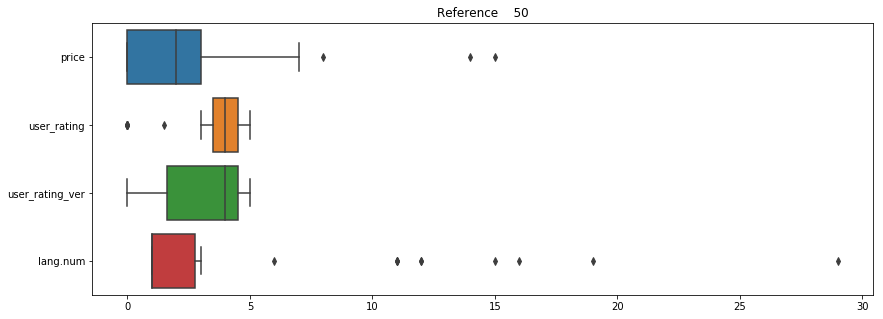

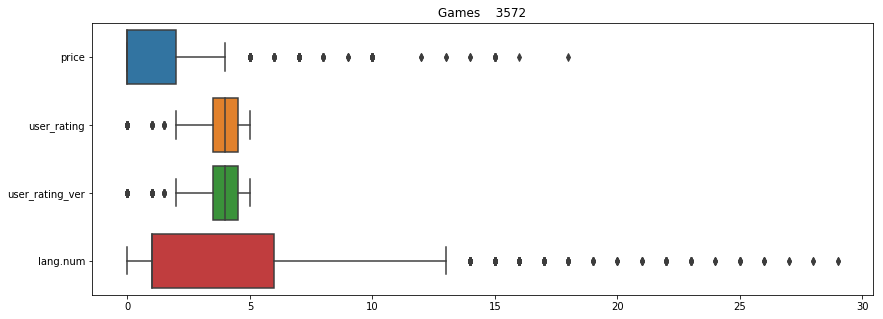

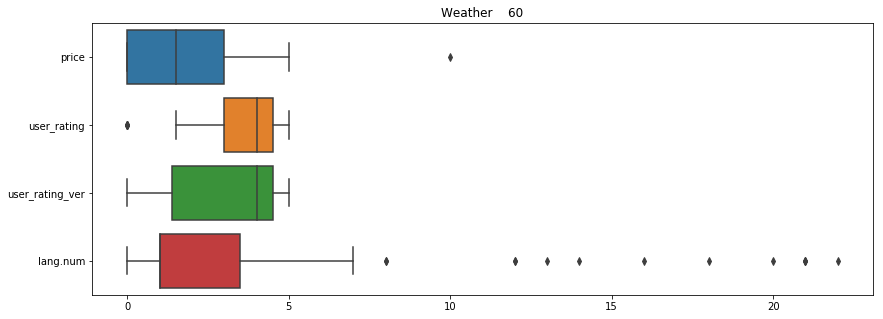

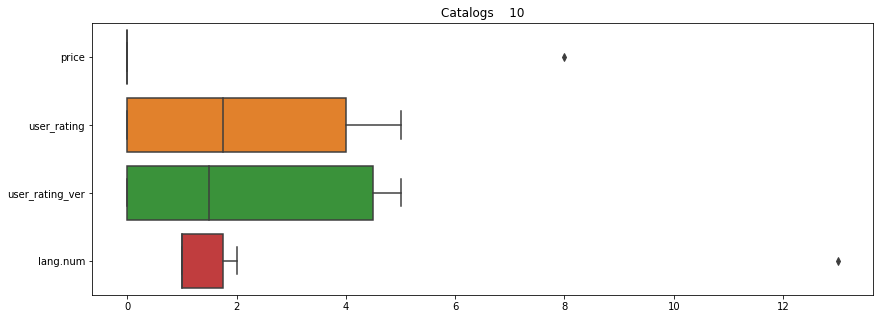

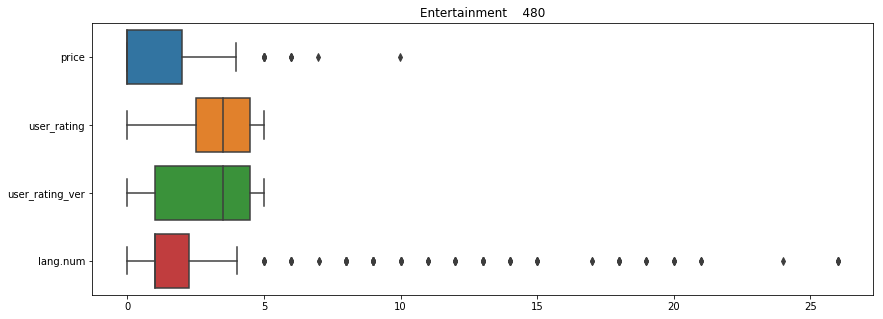

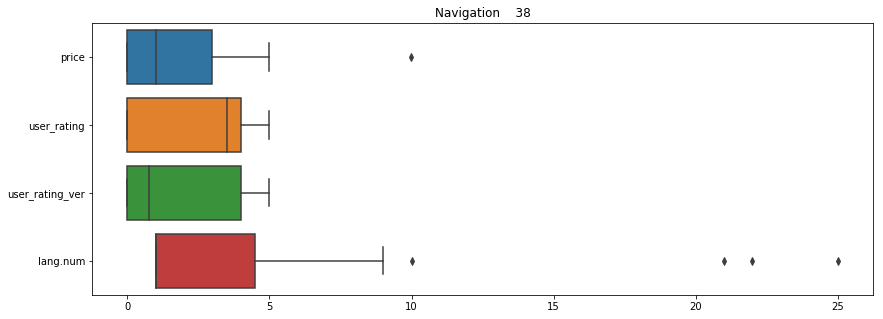

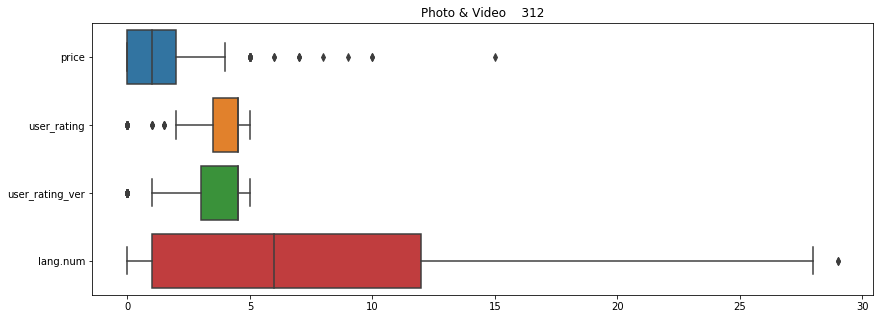

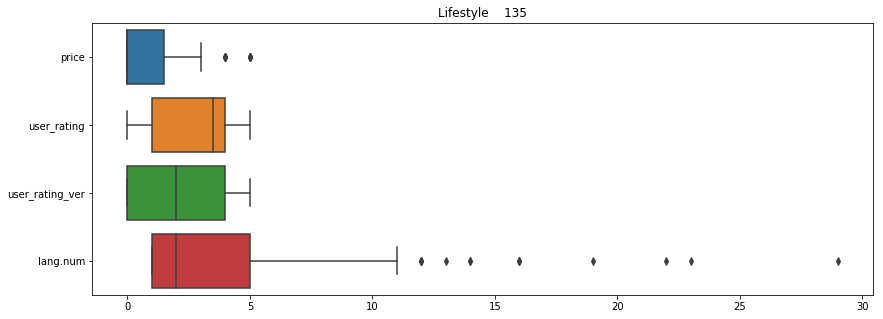

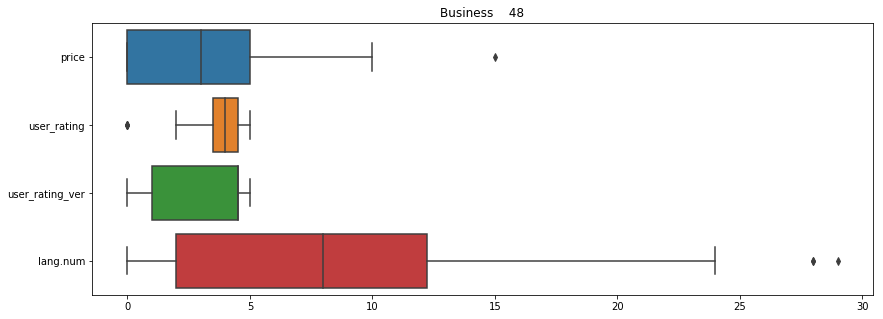

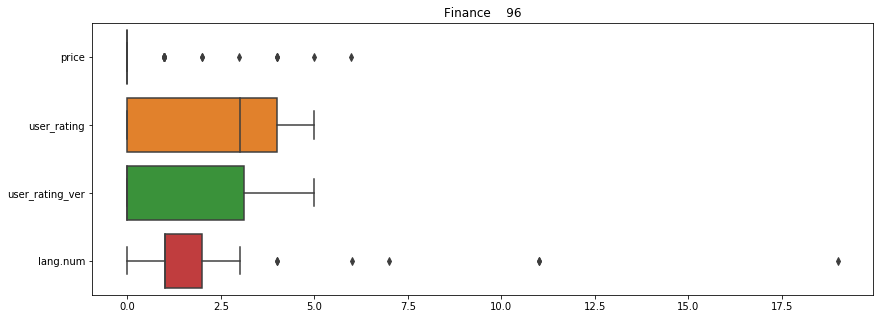

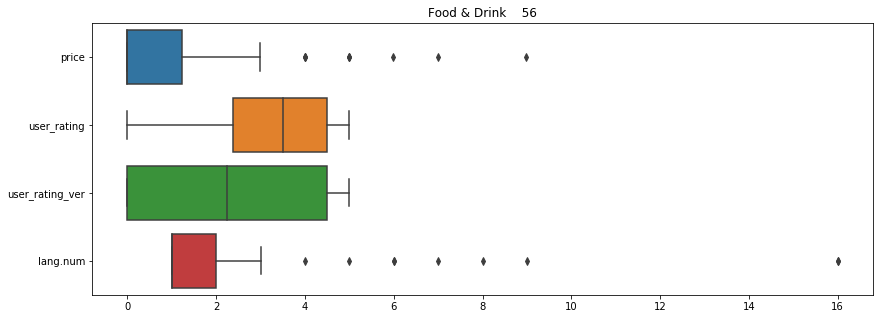

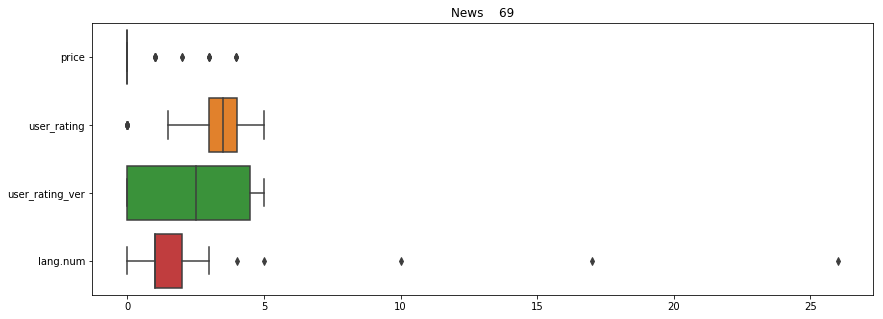

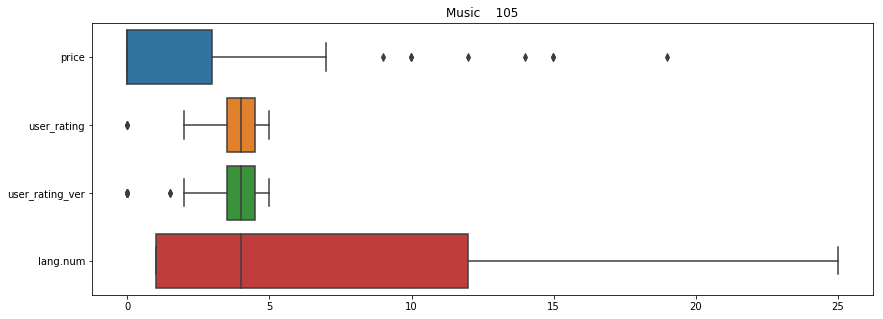

In [83]:
rcParams['figure.figsize'] = 14,5

for item in list_genres:
    
    sns.boxplot(data=div_genre["{0}".format(item)].drop(["rating_count_tot","rating_count_ver","sup_devices.num"],axis=1), 
                orient="h")
    
    plt.title('{0} '.format(item) +"   "+ str(div_genre["{0}".format(item)].shape[0]))
    plt.show() 

# HEATMAP DIVISA PER GENERE

QUALCOSA DI INTERESSANTE ESCE FUORI

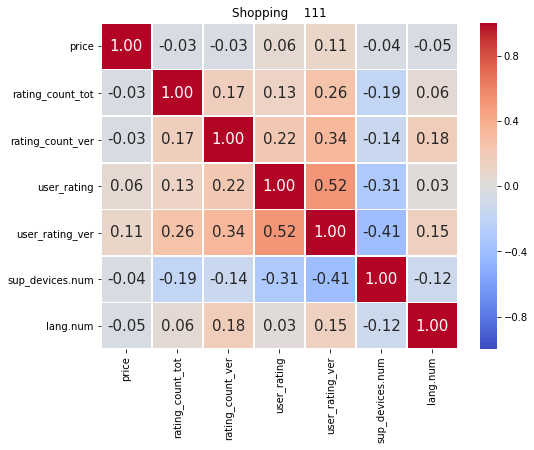

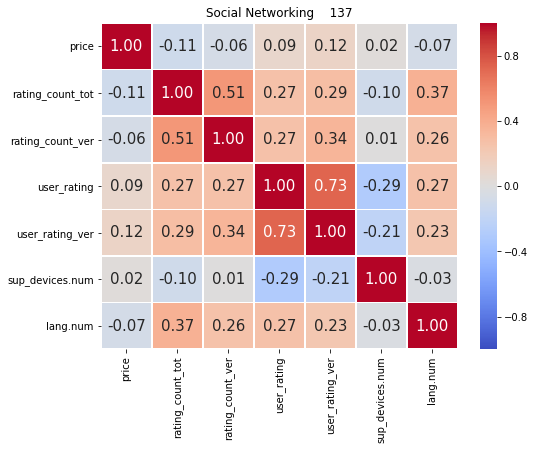

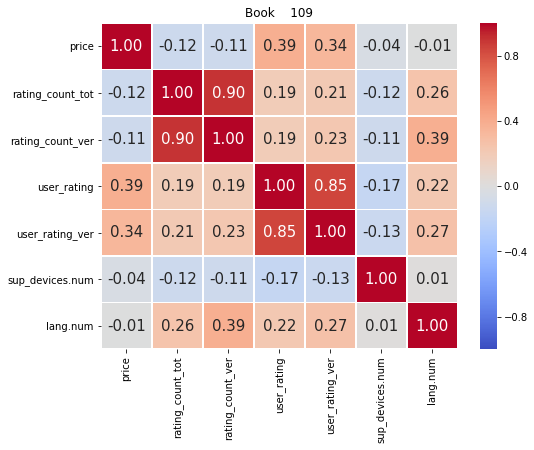

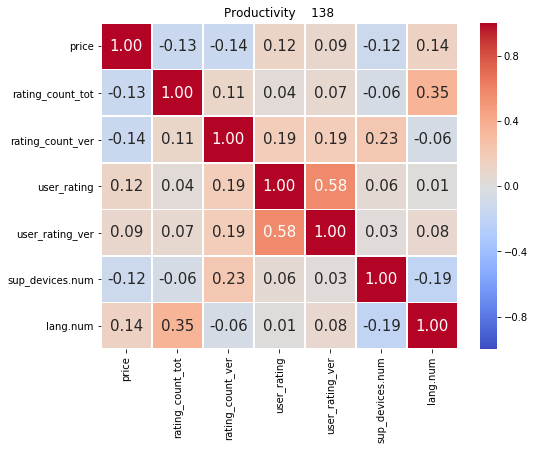

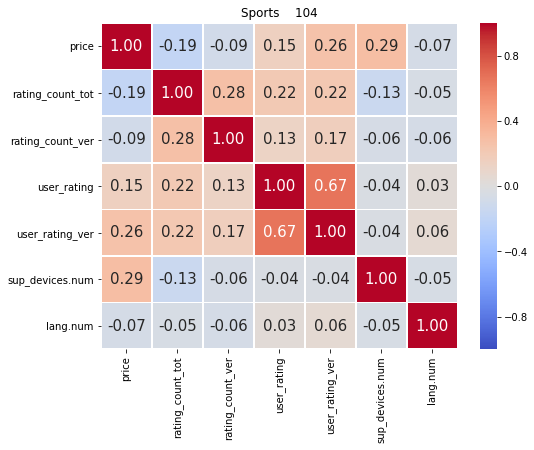

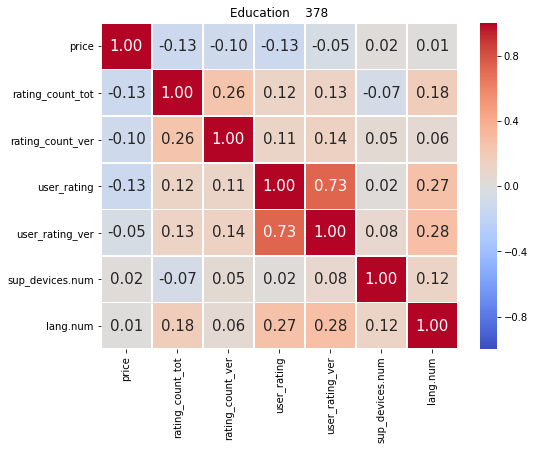

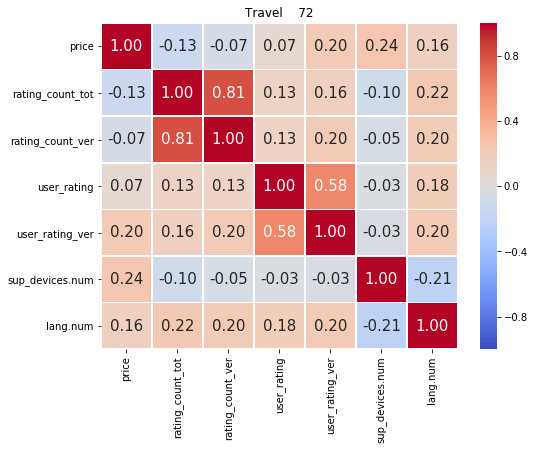

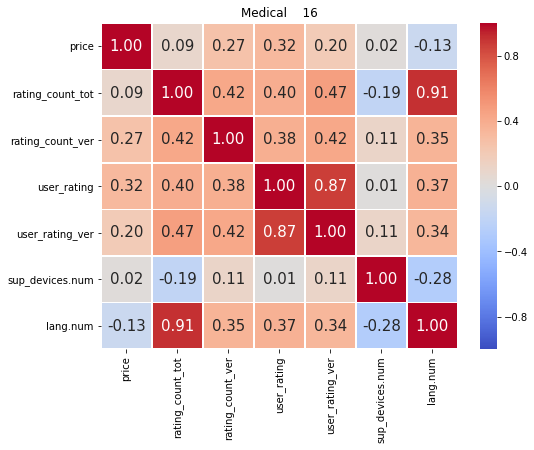

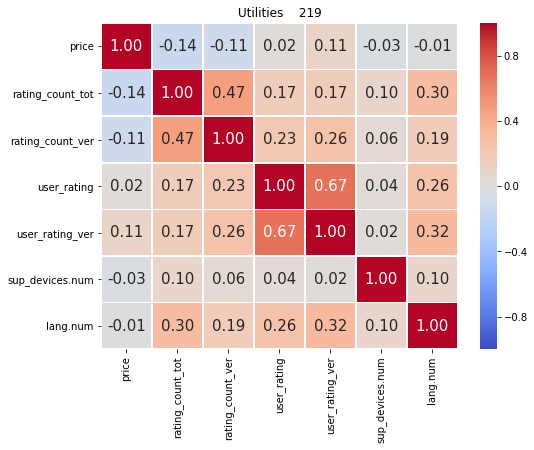

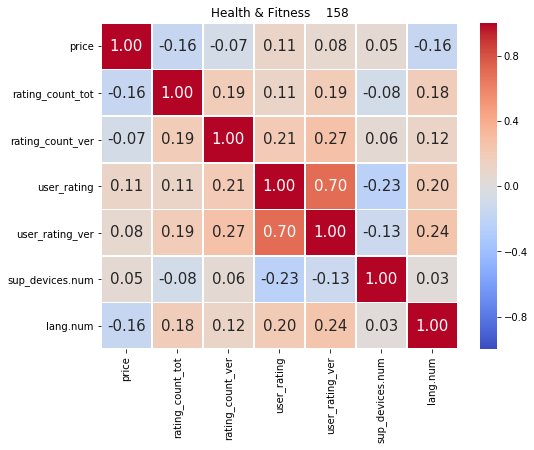

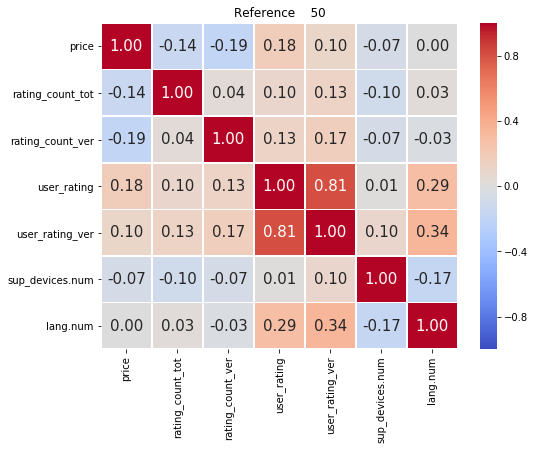

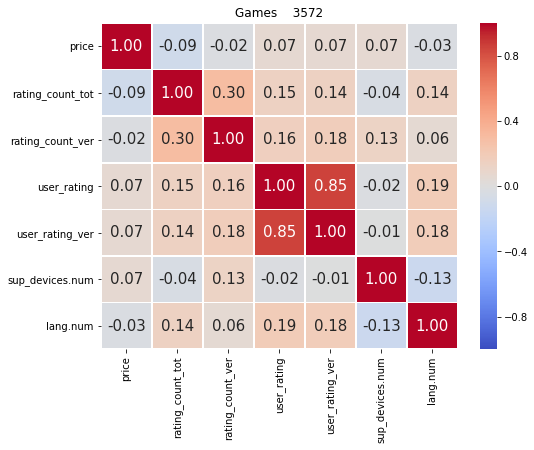

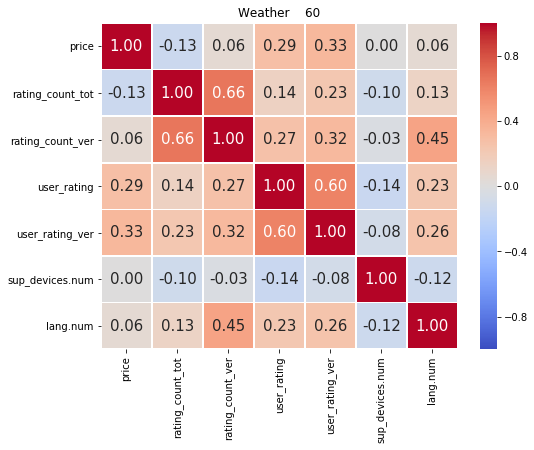

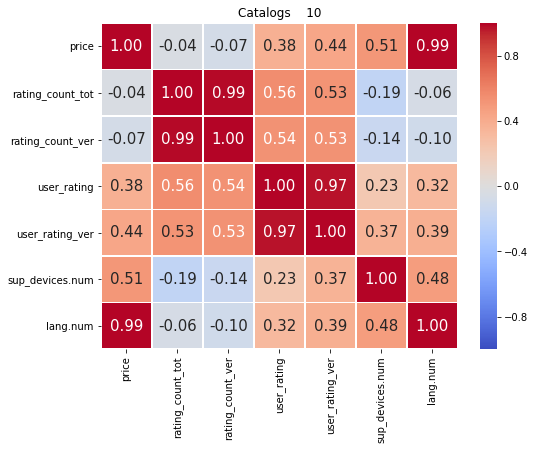

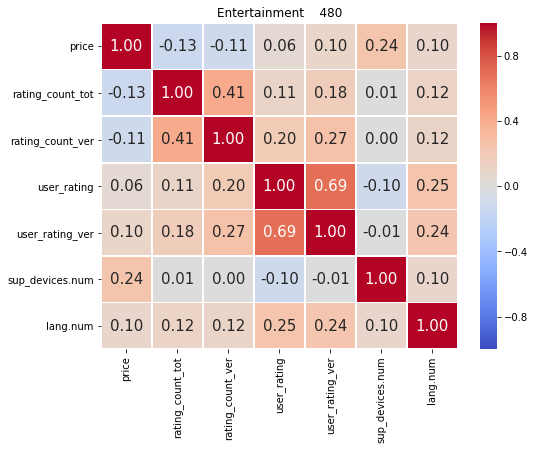

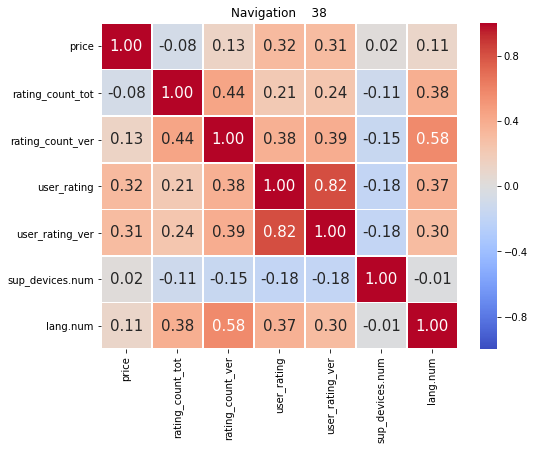

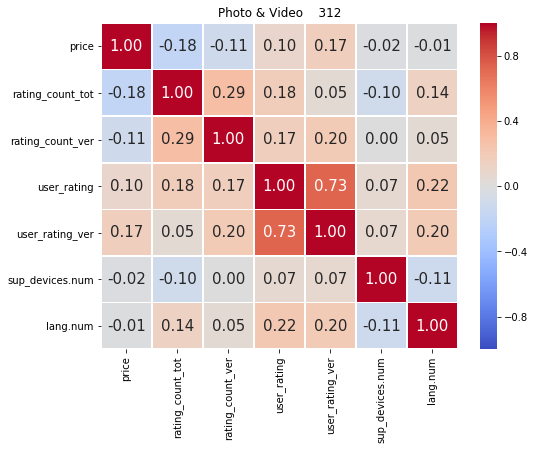

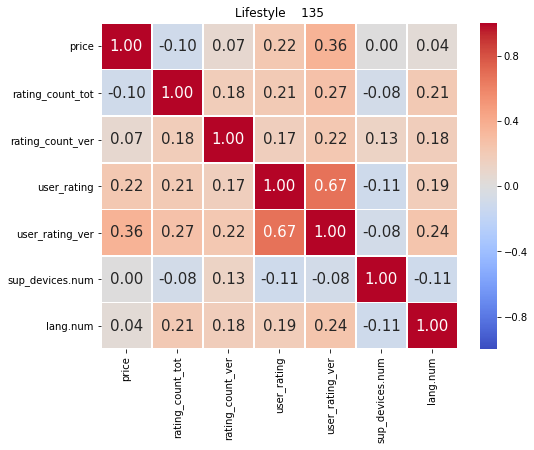

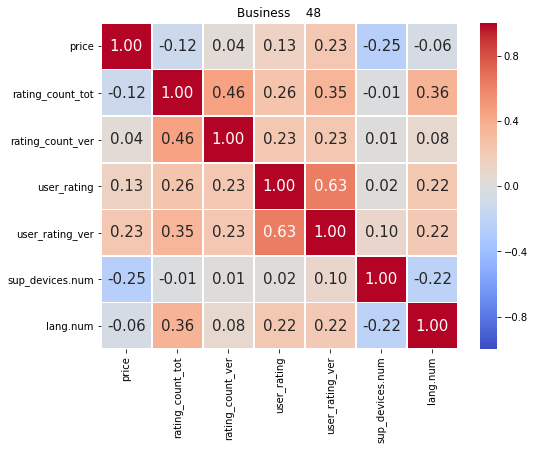

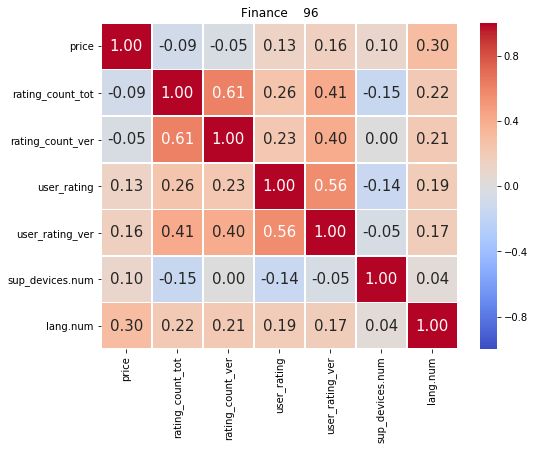

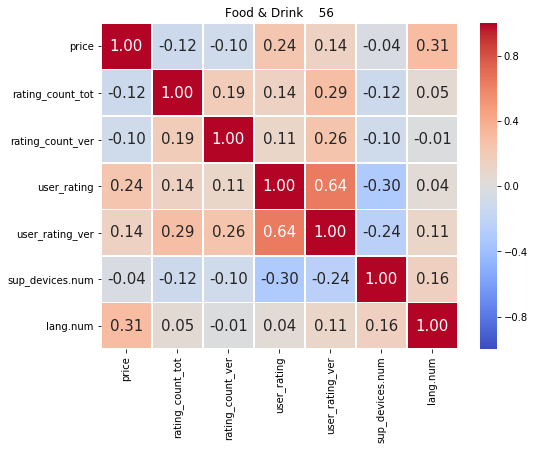

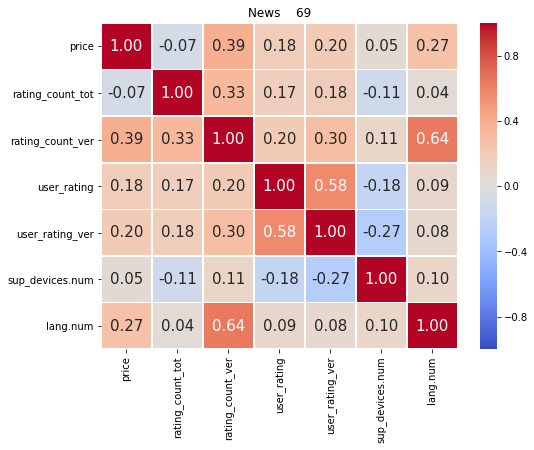

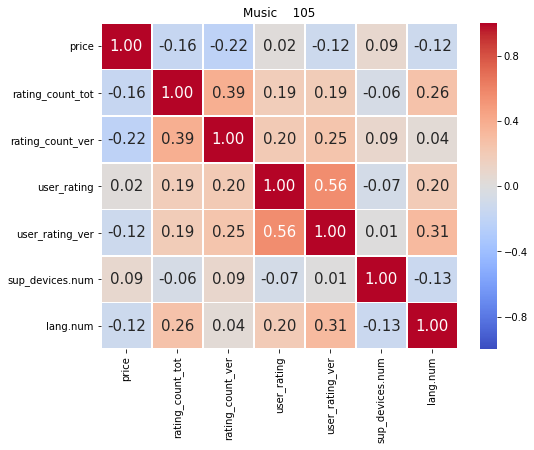

In [84]:
for item in list_genres:
    
    pino = div_genre["{0}".format(item)]#.drop(["rating_count_tot","rating_count_ver","sup_devices.num"],axis=1)
    
    corr = pino.corr()

    fig, ax = plt.subplots(figsize=(8,6))

    hm = sns.heatmap(corr,
                 ax=ax,
                 cmap='coolwarm',
                 vmin=-1.0,
                 vmax=1.0,
                 annot=True,
                 fmt='.2f',
                 annot_kws={'size':15},
                 linewidths=0.5)
    plt.title('{0} '.format(item) +"   "+ str(div_genre["{0}".format(item)].shape[0]))
    plt.show()

# voglio fare CHI SQUARE, inizio con free apps vs paid apps

obiettivo è vedere se le app free o quelle a pagamento sono rappresentative dell'intera popolazione, oppure se sono un gruppo "peculiare", non sapendo bene cosa significhi "peculiare" in tal caso

In [226]:
oper1=pd.qcut(df_tree["rating_count_tot"],q=10, labels=False, duplicates="drop")
oper2=pd.qcut(df_tree["rating_count_ver"], q=10, labels=False, duplicates="drop")
oper3=pd.qcut(df_tree["sup_devices.num"], q=10,labels=False, duplicates="drop" )
oper4=pd.qcut(df_tree["lang.num"], q=10, labels=False, duplicates="drop")
oper5=pd.qcut(df_tree["price"], q=10, labels=False, duplicates="drop")

In [86]:
#pd.qcut

In [227]:
import copy
df_copia=copy.deepcopy(df)
df_copia1=copy.deepcopy(df_tree)

In [228]:
df_copia1["rating_count_tot"]=oper1
df_copia1["rating_count_ver"]=oper2
df_copia1["sup_devices.num"]=oper3
df_copia1["lang.num"]=oper4
df_copia1["price"]=oper5

In [187]:
# df_copia.head(3)

In [229]:
df_free=df_copia1[df_copia1["price"]==0.00].reset_index(drop=True).drop(["price"],axis=1)
# df_free.head(2)

In [230]:
df_paid=df_copia1[df_copia1["price"]!=0.00].reset_index(drop=True).drop(["price"],axis=1)
# df_paid.head(2)

In [231]:
df_games_chi=df_copia1[df_copia1["prime_genre"]=="Games"].reset_index(drop=True).drop(["prime_genre"], axis=1)
# df_games_chi.head(3)

In [93]:
# df["rating_count_tot"].describe()

In [94]:
# df["rating_count_ver"].describe()

In [95]:
# df["sup_devices.num"].describe()

In [96]:
# df["lang.num"].describe()

In [122]:
#oper1.value_counts()

In [193]:
#oper2.value_counts()

In [99]:
#oper3.value_counts()

In [119]:
#oper4.value_counts()

In [194]:
#oper5.value_counts()

In [234]:
magna1=df_copia1.drop(["price"],axis=1)

In [235]:
magna2=df_copia1.drop(["prime_genre"],axis=1)

In [236]:
d1=list(magna1)
d2=list(magna2)


# ecco qua i vari p_value per le free apps e paid apps

vengono quasi sempre molto piccoli, ciò dovrebbe voler dire che sono gruppi NON rappresentativi dell'intera popolazione

In [237]:
for item in d1:
    observed=df_free[item].value_counts()
    national_ratios = magna1[item].value_counts()/len(magna1)
    expected = national_ratios * len(df_free)
    
    print(item)
    print(stats.chisquare(f_obs= observed.sort_index(),   
                          f_exp= expected.sort_index()))   

rating_count_tot
Power_divergenceResult(statistic=108.05513715067036, pvalue=9.553226753601016e-20)
rating_count_ver
Power_divergenceResult(statistic=61.45329935107969, pvalue=7.733685179268772e-11)
user_rating
Power_divergenceResult(statistic=45.81818301529178, pvalue=6.508587660043003e-07)
user_rating_ver
Power_divergenceResult(statistic=54.417419401223704, pvalue=1.5724310655809855e-08)
sup_devices.num
Power_divergenceResult(statistic=11.703129140524364, pvalue=0.008472490483119818)
ipadSc_urls.num
Power_divergenceResult(statistic=28.972301361976555, pvalue=2.3479512062659686e-05)
lang.num
Power_divergenceResult(statistic=29.16765886591997, pvalue=2.1495895820794026e-05)
cont_rating
Power_divergenceResult(statistic=22.210278506671855, pvalue=5.897848687702605e-05)
prime_genre
Power_divergenceResult(statistic=161.90655144350325, pvalue=2.6390450883520854e-23)


In [238]:
for item in d1:
    observed=df_paid[item].value_counts()
    national_ratios = magna1[item].value_counts()/len(magna1)
    expected = national_ratios * len(df_paid)
    #print(observed.sort_index())
    #print(expected.sort_index())
    print(item)
    print(stats.chisquare(f_obs= observed.sort_index(),   
                          f_exp= expected.sort_index())) 

rating_count_tot
Power_divergenceResult(statistic=227.2473090508107, pvalue=1.131475248900272e-44)
rating_count_ver
Power_divergenceResult(statistic=129.24047183757745, pvalue=9.057250938496457e-25)
user_rating
Power_divergenceResult(statistic=96.35875785622478, pvalue=8.557737940386075e-17)
user_rating_ver
Power_divergenceResult(statistic=114.44353735051216, pvalue=1.826527071516649e-20)
sup_devices.num
Power_divergenceResult(statistic=24.612477248073024, pvalue=1.8606453485853586e-05)
ipadSc_urls.num
Power_divergenceResult(statistic=60.93072199184631, pvalue=7.80436399026514e-12)
lang.num
Power_divergenceResult(statistic=61.3415721211845, pvalue=6.417407765892903e-12)
cont_rating
Power_divergenceResult(statistic=46.7097276168598, pvalue=4.0065565744598385e-10)
prime_genre
Power_divergenceResult(statistic=340.5004991287866, pvalue=6.8943410902461e-59)


# ora faccio chi squared per ogni prime_genre

In [239]:
for gigi in list_genres:
    
    df_chi=df_copia1[df_copia1["prime_genre"]==gigi].reset_index(drop=True).drop(["prime_genre"], axis=1)
    
    print("\n"+"{0}  ".format(gigi)+ str(div_genre["{0}".format(gigi)].shape[0])+"\n" )
    
    for item in d2:
        
        observed=df_chi[item].value_counts()
        national_ratios = magna2[item].value_counts()/len(magna2)
        expected = national_ratios * len(df_chi)
        
        for i in expected.index:
            if i not in observed.index:
                observed = observed.append(pd.Series([0], index=[i]))
        
        print(item)
        print(stats.chisquare(f_obs= observed.sort_index(),   
                              f_exp= expected.sort_index())) 


Shopping  111

price
Power_divergenceResult(statistic=49.94218809325827, pvalue=3.712631912275399e-10)
rating_count_tot
Power_divergenceResult(statistic=25.727479821638852, pvalue=0.0011691920422632765)
rating_count_ver
Power_divergenceResult(statistic=19.19482249128928, pvalue=0.007598452781443077)
user_rating
Power_divergenceResult(statistic=10.511496436093825, pvalue=0.3106833582795838)
user_rating_ver
Power_divergenceResult(statistic=27.674217507829024, pvalue=0.0010810246931407278)
sup_devices.num
Power_divergenceResult(statistic=63.62716386169007, pvalue=9.862108891505194e-14)
ipadSc_urls.num
Power_divergenceResult(statistic=99.61269874137723, pvalue=6.377945116644352e-20)
lang.num
Power_divergenceResult(statistic=21.479238294946306, pvalue=0.000657412776805825)
cont_rating
Power_divergenceResult(statistic=14.637682901506908, pvalue=0.0021539722896655716)

Social Networking  137

price
Power_divergenceResult(statistic=41.62065926060403, pvalue=1.9991754238539644e-08)
rating_coun

rating_count_tot
Power_divergenceResult(statistic=4.527488576895024, pvalue=0.8066767018131069)
rating_count_ver
Power_divergenceResult(statistic=2.0140252407685675, pvalue=0.9590600232711458)
user_rating
Power_divergenceResult(statistic=6.3361993082852965, pvalue=0.7058553037008504)
user_rating_ver
Power_divergenceResult(statistic=2.992584729566984, pvalue=0.9645882347267555)
sup_devices.num
Power_divergenceResult(statistic=6.125696507282634, pvalue=0.10565241294642096)
ipadSc_urls.num
Power_divergenceResult(statistic=19.357245271928097, pvalue=0.0016487372770160142)
lang.num
Power_divergenceResult(statistic=5.895810267785674, pvalue=0.3164894359127241)
cont_rating
Power_divergenceResult(statistic=7.222740010809194, pvalue=0.06512716825105552)

Games  3572

price
Power_divergenceResult(statistic=28.837999781643415, pvalue=8.432650835983926e-06)
rating_count_tot
Power_divergenceResult(statistic=14.705530509578704, pvalue=0.06513056837090002)
rating_count_ver
Power_divergenceResult(stat

rating_count_tot
Power_divergenceResult(statistic=10.574076691321505, pvalue=0.22701945768896342)
rating_count_ver
Power_divergenceResult(statistic=19.1912213011735, pvalue=0.007608958155807853)
user_rating
Power_divergenceResult(statistic=12.122810382758841, pvalue=0.20647407533442758)
user_rating_ver
Power_divergenceResult(statistic=20.961961198104184, pvalue=0.01282039377982649)
sup_devices.num
Power_divergenceResult(statistic=18.3907680404596, pvalue=0.00036531729222579335)
ipadSc_urls.num
Power_divergenceResult(statistic=48.980136215646006, pvalue=2.2400945895858276e-09)
lang.num
Power_divergenceResult(statistic=14.428780055278533, pvalue=0.013103347288478907)
cont_rating
Power_divergenceResult(statistic=9.214775859125101, pvalue=0.026567504233547704)

News  69

price
Power_divergenceResult(statistic=14.272976382000824, pvalue=0.006472909826396131)
rating_count_tot
Power_divergenceResult(statistic=13.459705101943971, pvalue=0.09698111754835811)
rating_count_ver
Power_divergenceRes

# ora faccio dei bar plot per le varie colonne dei vari generi

In [244]:
pierangelo=df_tree.groupby(["prime_genre"]).describe()

In [278]:
# pierangelo["mean_tot"]

In [279]:
# pierangelo["price"].iloc[:,1:3]

In [318]:
d3=list(df_tree)
d3.remove("prime_genre")
d3.remove("cont_rating")

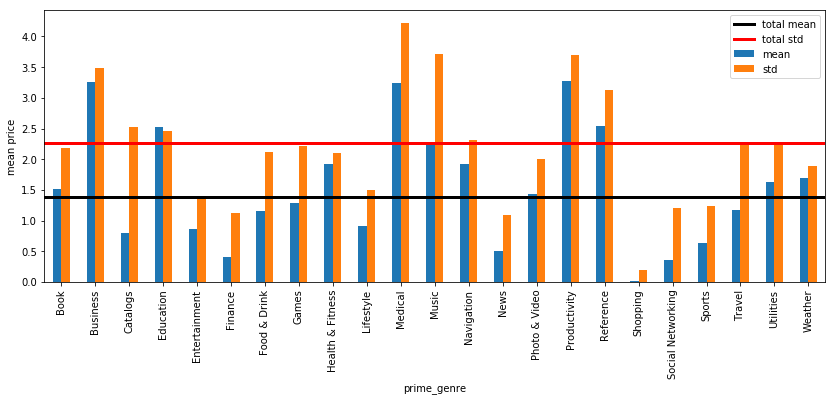

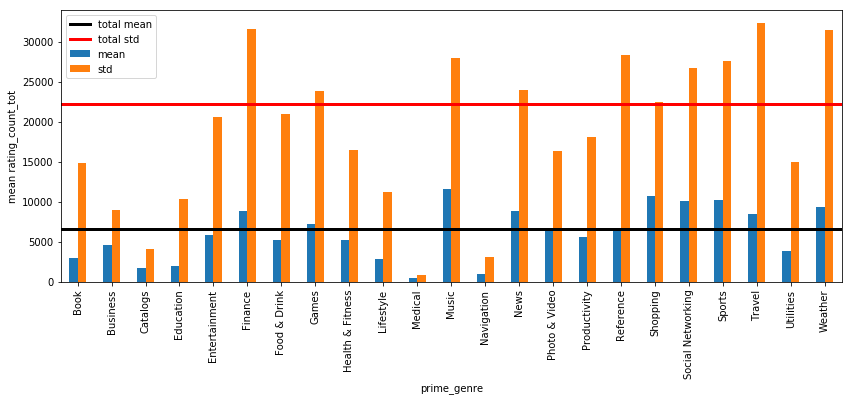

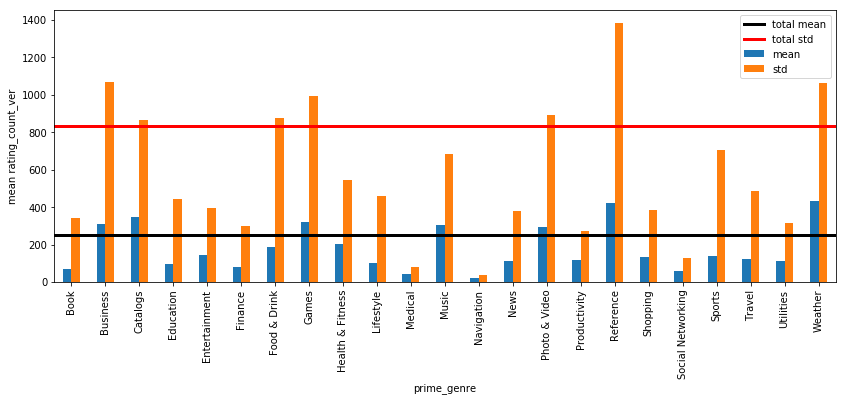

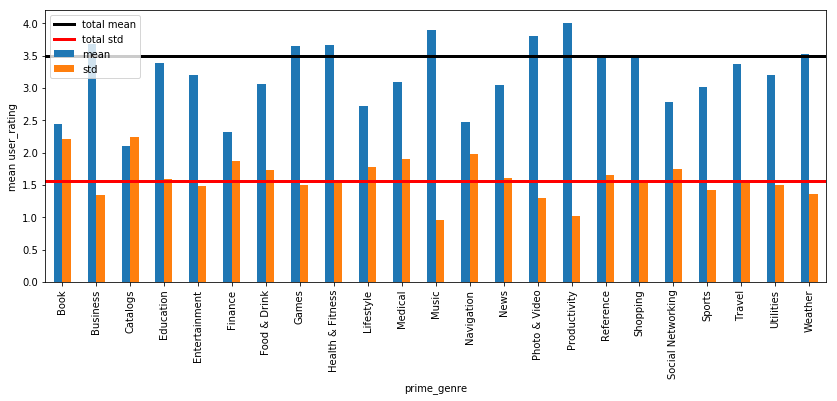

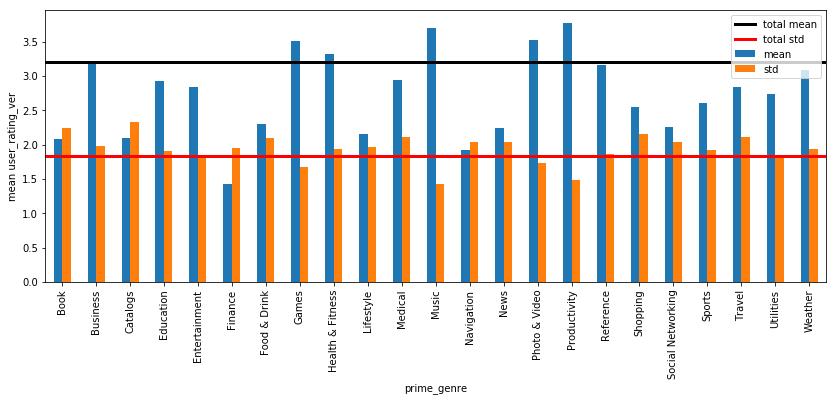

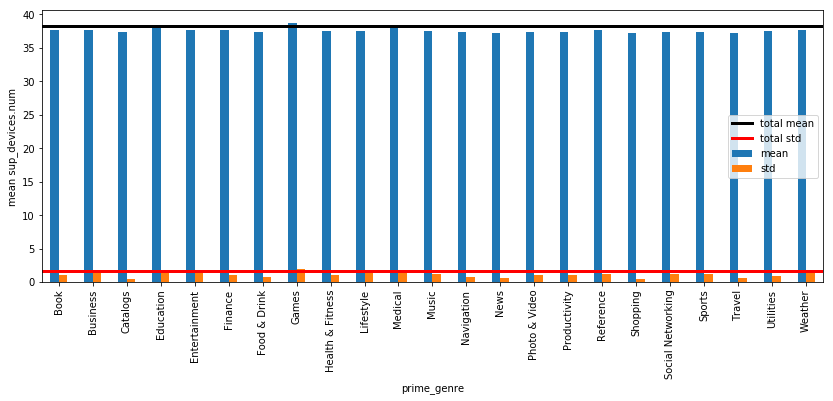

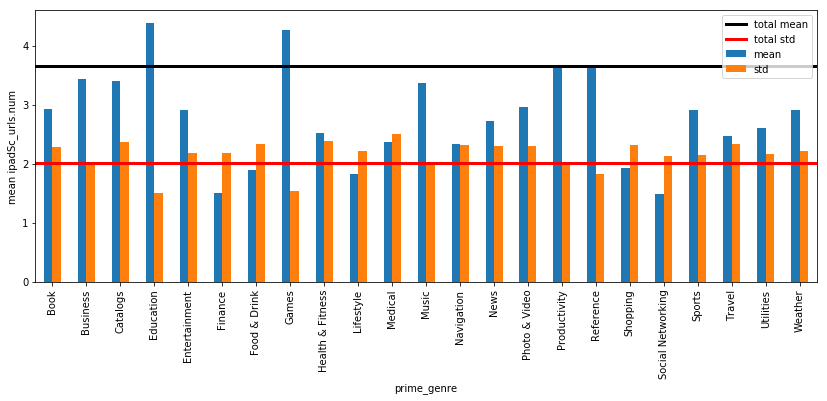

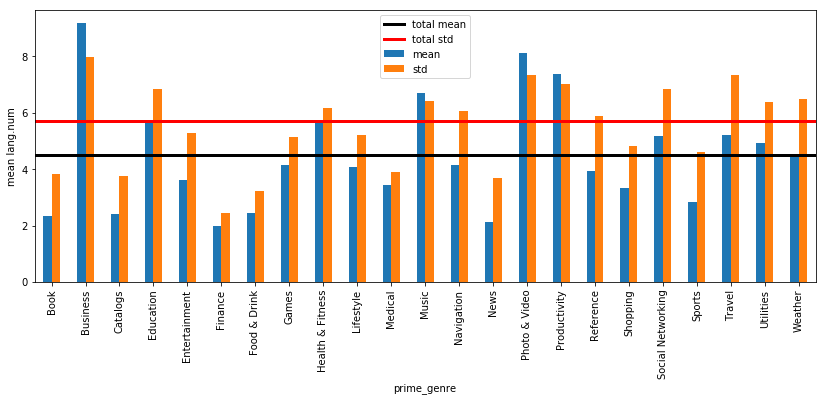

In [319]:
for item in d3:
    
    pierangelo["{0}".format(item)].iloc[:,1:3].plot(kind="bar")
    
    plt.axhline(df_nocat_noout["{0}".format(item)].mean(), color="black", linewidth=3, label="total mean")
    plt.axhline(df_nocat_noout["{0}".format(item)].std(), color="red", linewidth=3, label="total std")
    
    plt.ylabel("mean {0}".format(item))
    plt.legend()
    plt.show()